## Import dependencies

In [1]:
# Download detr repos
!git clone https://github.com/facebookresearch/detr.git 

Cloning into 'detr'...
remote: Enumerating objects: 243, done.
remote: Total 243 (delta 0), reused 0 (delta 0), pack-reused 243
Receiving objects: 100% (243/243), 12.84 MiB | 30.66 MiB/s, done.
Resolving deltas: 100% (127/127), done.


In [2]:
!pip install utils
!pip install glob2
!pip install --upgrade pip

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
  Created wheel for glob2: filename=glob2-0.7-py2.py3-none-any.whl size=9307 sha256=63f577a25f1ec412ba5a946eb7634b95b5631e5b3973af2d365b0512893f1990
  Stored in directory: /root/.cache/pip/wheels/d7/3c/72/5300602ba1269ffce8cff5dcf7b525fee756b57455903c37ba
Successfully built glob2
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 1.5 MB 4.7 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 21.0
    Uninstalling pip-21.0:
      Successfully uninstalled pip-21.0


In [3]:
# basic
import os
import numpy as np 
import pandas as pd 
from tqdm.autonotebook import tqdm

#computer vison module
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

#pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler

#for K-fold cross validation
from sklearn.model_selection import StratifiedKFold

#Hungarian loss & bipartite matcher
import sys
sys.path.append('./detr/')

from detr.models.matcher import HungarianMatcher
from detr.models.detr import SetCriterion

#Data aug
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

#Glob
from glob2 import glob

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  """


# Data pre-processing

In [4]:
train_dir = '../input/global-wheat-detection/train/'
test_dir = '../input/global-wheat-detection/test/'

train_annos = '../input/global-wheat-detection/train.csv'

# glob to get lists of files of each dir 
train_fns = glob(train_dir + '*')
test_fns = glob(test_dir + '*')

In [5]:
print('Number of train images: ', len(train_fns))
print('Number of test images: ', len(test_fns))

Number of train images:  3422
Number of test images:  10


In [6]:
train = pd.read_csv(train_annos)
train

image_id  width  height                         bbox     source
0       b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]    usask_1
1       b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]    usask_1
2       b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]    usask_1
3       b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]    usask_1
4       b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]    usask_1
...           ...    ...     ...                          ...        ...
147788  5e0747034   1024    1024    [64.0, 619.0, 84.0, 95.0]  arvalis_2
147789  5e0747034   1024    1024  [292.0, 549.0, 107.0, 82.0]  arvalis_2
147790  5e0747034   1024    1024  [134.0, 228.0, 141.0, 71.0]  arvalis_2
147791  5e0747034   1024    1024   [430.0, 13.0, 184.0, 79.0]  arvalis_2
147792  5e0747034   1024    1024   [875.0, 740.0, 94.0, 61.0]  arvalis_2

[147793 rows x 5 columns]

In [7]:
#Create dataframe with all training images
all_train_images = pd.DataFrame([fns.split('/')[-1][:-4] for fns in train_fns])
all_train_images.columns=['image_id']

#Merge with bboxes
all_train_images = all_train_images.merge(train, on='image_id', how='left')

#Fill nan values with zero
all_train_images['bbox'] = all_train_images.bbox.fillna('[0,0,0,0]')

#Split 4 values of bbox to columns
bbox_items = all_train_images.bbox.str.split(',', expand = True)

all_train_images['x_min'] = bbox_items[0].str.strip('[ ').astype(float)
all_train_images['y_min'] = bbox_items[1].str.strip(' ').astype(float)
all_train_images['width'] = bbox_items[2].str.strip(' ').astype(float)
all_train_images['height'] = bbox_items[3].str.strip('] ').astype(float)

In [8]:
# Check imgs without bboxes.
print('There are {} images with no bounding box!'.format(len(all_train_images)- len(train)))

There are 49 images with no bounding box!


In [9]:
# Remove img without bboxes.
all_train_images = all_train_images[all_train_images.width != 0]

print('There are {} images with no bounding box!'.format(len(all_train_images)- len(train)))

There are 0 images with no bounding box!


In [10]:
# This code is used for connecting boxes with id, we partly get from UIT LOGO baseline. 
def get_all_bboxes(df, image_id):
    image_bboxes = df[df.image_id == image_id]   
    bboxes = []
    for _,row in image_bboxes.iterrows():
        bboxes.append((row.x_min, row.y_min, row.width, row.height))
        
    return bboxes

def plot_image_examples(df, rows=3, cols=3):
    fig, axs = plt.subplots(rows, cols, figsize=(25,20))
    for row in range(rows):
        for col in range(cols):
            idx = np.random.randint(len(df), size=1)[0]
            img_id = df.iloc[idx].image_id
            
            img = Image.open(train_dir + img_id + '.jpg')
            axs[row, col].imshow(img)
            
            bboxes = get_all_bboxes(df, img_id)
            
            for bbox in bboxes:
                rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],linewidth=1,edgecolor='r',facecolor='none')
                axs[row, col].add_patch(rect)
            
            axs[row, col].axis('off')

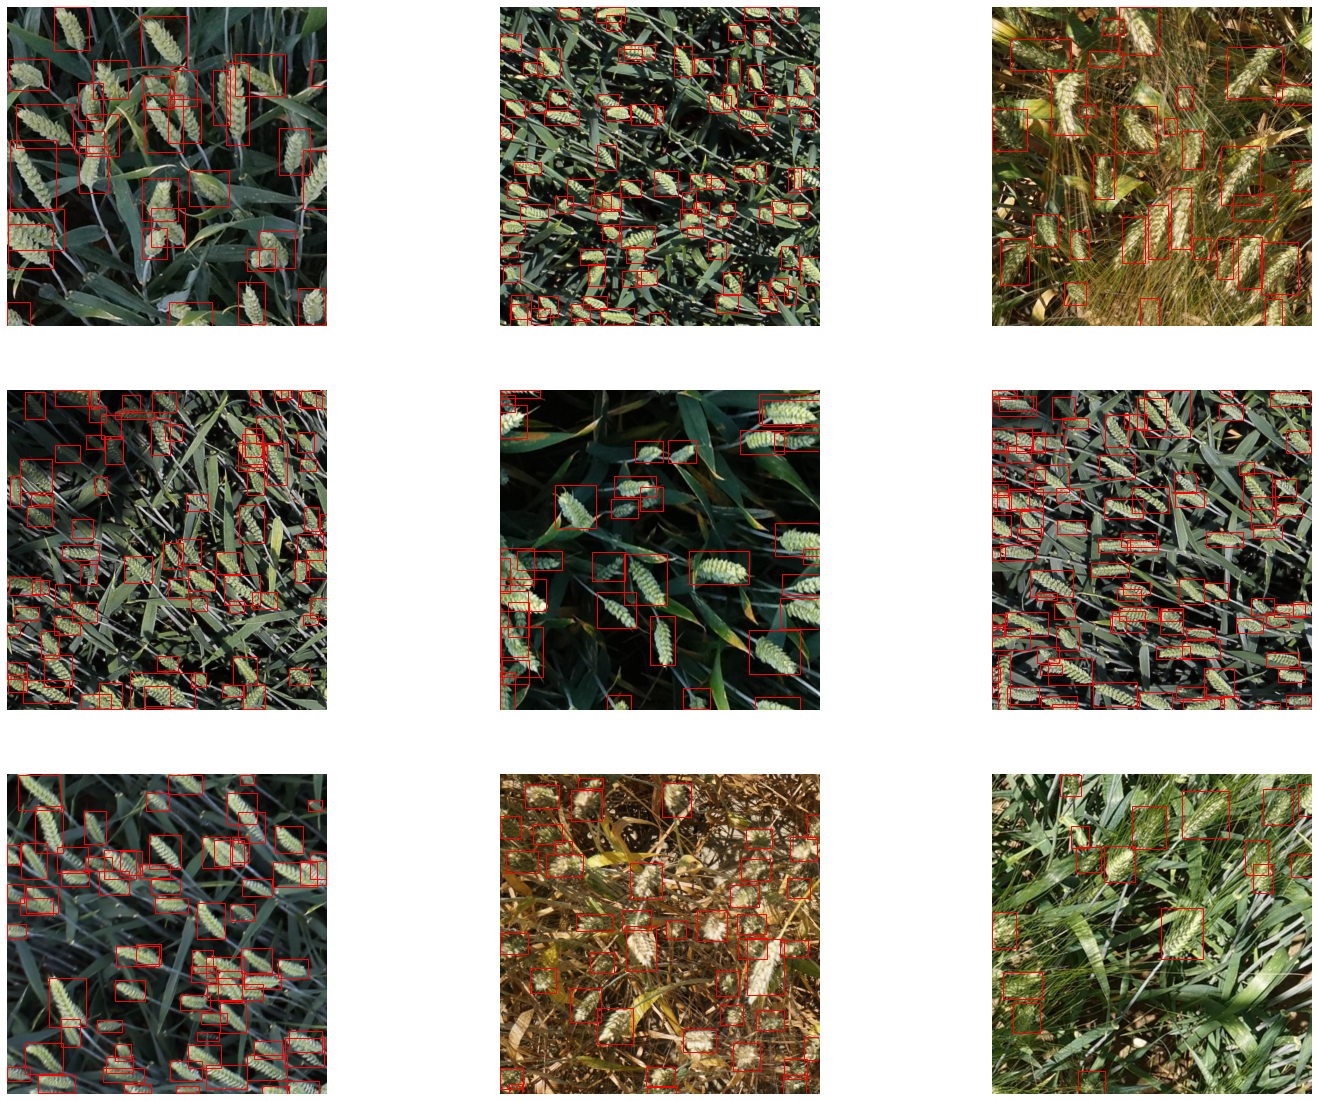

In [11]:
# Sample images with bounding box.
plot_image_examples(all_train_images)

In [12]:
# Drop old bbox column
all_train_images.drop(columns = ['bbox'], inplace=True)

# Count bbox with condition
all_train_images['count'] = all_train_images.apply(lambda row: 1 if np.isfinite(row.width) else 0, axis=1)

all_train_images

image_id  width  height     source  x_min  y_min  count
0       944c60a15   69.0    49.0  arvalis_1  336.0   54.0      1
1       944c60a15   79.0    45.0  arvalis_1  218.0    0.0      1
2       944c60a15   56.0    65.0  arvalis_1    2.0    0.0      1
3       944c60a15   71.0    96.0  arvalis_1  588.0  256.0      1
4       944c60a15   61.0    80.0  arvalis_1  257.0  251.0      1
...           ...    ...     ...        ...    ...    ...    ...
147837  667b4a999   67.0    94.0  arvalis_2  939.0   87.0      1
147838  667b4a999   62.0    75.0  arvalis_2   12.0  821.0      1
147839  667b4a999   64.0    72.0  arvalis_2  502.0  399.0      1
147840  667b4a999   46.0    68.0  arvalis_2  491.0  305.0      1
147841  667b4a999   63.0    78.0  arvalis_2  506.0  215.0      1

[147793 rows x 7 columns]

## Creating Fold

In [13]:
# Config
n_folds = 4
seed = 42
num_classes = 2 #(wheat and no-obj class)
num_queries = 100
null_class_coef = 0.5
BATCH_SIZE = 12
LR = 2e-5
EPOCHS = 10

In [14]:
"""[1]"""

skf = StratifiedKFold(n_splits= n_folds, shuffle=True, random_state=42)

df_folds = all_train_images[['image_id', 'count']].copy()

#Gather all boxes of each img 
df_folds = df_folds.groupby('image_id').count()

#Get source for each img, we stratify to 4 folds.
df_folds.loc[:, 'source'] = all_train_images[['image_id', 'source']].groupby('image_id').min()['source']
df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['source'].values.astype(str),
    df_folds['count'].apply(lambda x: f'_{x // 15}').values.astype(str)
    )

df_folds.loc[:, 'fold'] = 0

for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)


In [15]:
df_folds

count     source stratify_group  fold
image_id                                        
00333207f     55  arvalis_1    arvalis_1_3     1
005b0d8bb     20    usask_1      usask_1_1     3
006a994f7     25    inrae_1      inrae_1_1     0
00764ad5d     41    inrae_1      inrae_1_2     0
00b5fefed     25  arvalis_3    arvalis_3_1     2
...          ...        ...            ...   ...
ffb445410     57     rres_1       rres_1_3     1
ffbf75e5b     52  arvalis_1    arvalis_1_3     1
ffbfe7cc0     34  arvalis_1    arvalis_1_2     2
ffc870198     41    usask_1      usask_1_2     3
ffdf83e42     39  arvalis_1    arvalis_1_2     3

[3373 rows x 4 columns]

## Create dataset object

In [16]:
"""[2]"""
class WheatDataset(Dataset):
    
    def __init__(self,image_ids,dataframe,transforms=None):
        self.image_ids = image_ids
        self.df = dataframe        
        
        #Data augmentation 
        self.transforms = transforms
        
        
    def __len__(self) -> int:
        return self.image_ids.shape[0]
    
    def __getitem__(self,index):
        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]
        
        image = cv2.imread(f'{train_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        # DETR takes in data in coco format 
        boxes = records[['x_min', 'y_min', 'width', 'height']].values
        
        #Area of bb
        area = boxes[:,2]*boxes[:,3]
        area = torch.as_tensor(area, dtype=torch.float32)
        
        labels =  np.zeros(len(boxes), dtype=np.int32)
        
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': boxes,
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            boxes = sample['bboxes']
            labels = sample['labels']            
            
        #Normalizing BBOXES            
        _,h,w = image.shape
        boxes = A.augmentations.bbox_utils.normalize_bboxes(sample['bboxes'],rows=h,cols=w)
        target = {}
        target['boxes'] = torch.as_tensor(boxes,dtype=torch.float32)
        target['labels'] = torch.as_tensor(labels,dtype=torch.long)
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        
        return image, target, image_id

## Create DETR object

In [17]:
"""[3]"""
class DETRModel(nn.Module):
    def __init__(self,num_classes,num_queries):
        super(DETRModel,self).__init__()
        self.num_classes = num_classes
        self.num_queries = num_queries
        
        #Download pretrained DETR model with backbone resnet101 feature extractor.
        self.model = torch.hub.load('facebookresearch/detr', 'detr_resnet101', pretrained=True)
        self.in_features = self.model.class_embed.in_features
        
        self.model.class_embed = nn.Linear(in_features=self.in_features,out_features=self.num_classes)
        self.model.num_queries = self.num_queries
        
    def forward(self,images):
        return self.model(images)

In [18]:
#Create matcher for loss calculation and set "lambda" params
# loss_ce: classification loss (Hungarian matching loss)
# loss_bbox: bbox loss
# giou: giou loss

matcher = HungarianMatcher()

weight_dict = {'loss_ce': 1, 'loss_bbox': 1 , 'loss_giou': 1}

losses = ['labels', 'boxes', 'cardinality']

## Data Augmentation

In [19]:
"""[4]"""
def get_train_transforms():
    return A.Compose([A.OneOf([A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, val_shift_limit=0.2, p=0.9),                               
                      A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.9)],p=0.9),                      
                      A.ToGray(p=0.01),                      
                      A.HorizontalFlip(p=0.5),                      
                      A.VerticalFlip(p=0.5),                      
                      A.Resize(height=512, width=512, p=1),                      
                      A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),                      
                      ToTensorV2(p=1.0)],                      
                      p=1.0,                     
                      bbox_params=A.BboxParams(format='coco',min_area=0, min_visibility=0,label_fields=['labels'])
                      )


def get_valid_transforms():
    return A.Compose([A.Resize(height=512, width=512, p=1.0),
                      ToTensorV2(p=1.0)], 
                      p=1.0, 
                      bbox_params=A.BboxParams(format='coco',min_area=0, min_visibility=0,label_fields=['labels'])
                      )

## Loss calculation object

In [20]:
# To compute and store avg and current value.
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [21]:
def train_fn(data_loader,model,criterion,optimizer,device,scheduler,epoch):
    
    model.train()
    criterion.train()
    
    summary_loss = AverageMeter()
    
    with tqdm(data_loader, total=len(data_loader)) as tk0:
    
        for step, (images, targets, image_ids) in enumerate(tk0):
        
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        

            output = model(images)
        
            loss_dict = criterion(output, targets)
            weight_dict = criterion.weight_dict
        
            losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
        
            optimizer.zero_grad()

            losses.backward()
            optimizer.step()
            
            if scheduler is not None:
                scheduler.step()
        
            summary_loss.update(losses.item(),BATCH_SIZE)
            tk0.set_postfix(loss=summary_loss.avg)
        
    return summary_loss

In [22]:
def eval_fn(data_loader, model,criterion, device):
    
    model.eval()
    criterion.eval()
    
    summary_loss = AverageMeter()
    
    # Disabled gradient calculation over the weights
    with torch.no_grad():
        
        tk0 = tqdm(data_loader, total=len(data_loader))
        for step, (images, targets, image_ids) in enumerate(tk0):
            
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            output = model(images)
        
            loss_dict = criterion(output, targets)
            weight_dict = criterion.weight_dict
        
            losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
            
            summary_loss.update(losses.item(),BATCH_SIZE)
            tk0.set_postfix(loss=summary_loss.avg)
    
    return summary_loss

# Training

In [23]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [24]:
"""[5]"""
def get_data_loader(fold):    
    df_train = df_folds[df_folds['fold'] != fold]
    df_valid = df_folds[df_folds['fold'] == fold]

    train_dataset = WheatDataset(
        image_ids=df_train.index.values,
        dataframe=all_train_images,
        transforms=get_train_transforms()
        )

    train_data_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=4,
        collate_fn=collate_fn
        )

    valid_dataset = WheatDataset(
        image_ids=df_valid.index.values,
        dataframe=all_train_images,
        transforms=get_valid_transforms()
        )

    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=4,
        collate_fn=collate_fn
        )
    
    return train_data_loader, valid_data_loader

In [25]:
def trainnnn(train_data_loader, valid_data_loader, device, model, criterion, optimizer, fold, best_loss, index):
    for epoch in range(EPOCHS):
        train_loss = train_fn(train_data_loader, model,criterion, optimizer,device,scheduler=None,epoch=epoch)
        valid_loss = eval_fn(valid_data_loader, model,criterion, device)
        
        print('|EPOCH {}| TRAIN_LOSS {}| VALID_LOSS {}|'.format(epoch+1,train_loss.avg,valid_loss.avg))
        
        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            print('Best model found for Fold {} in Epoch {}........Saving Model'.format(fold,epoch+1))
            torch.save(model.state_dict(), f'THE_BEST_{index}_fold_{fold}.pth')
        
        index+=1

In [26]:
#Set device, load model and set criteron
device = torch.device('cuda')

model = DETRModel(num_classes=num_classes, num_queries=num_queries)
model = model.to(device)

criterion = SetCriterion(num_classes-1, matcher, weight_dict, eos_coef = null_class_coef, losses=losses)
criterion = criterion.to(device)

Downloading: "https://github.com/facebookresearch/detr/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r101-2c7b67e5.pth" to /root/.cache/torch/hub/checkpoints/detr-r101-2c7b67e5.pth


  0%|          | 0.00/232M [00:00<?, ?B/s]

In [ ]:
best_loss = 10**5
index = 0
    
#AdamW optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

#Train 4 folds, each fold 10 epochs.
for fold in range(n_folds):
    train_data_loader, valid_data_loader = get_data_loader(fold=fold)
    trainnnn(train_data_loader, valid_data_loader, device, model, criterion, optimizer, fold, best_loss, index)

# Recall and test model 

In [27]:
#Recall model
device = torch.device("cuda")

model = DETRModel(num_classes = num_classes, num_queries=num_queries)
model.load_state_dict(torch.load('../input/best-model/THE_BEST_9_fold_3.pth'))
# model.load_state_dict(torch.load('./THE_BEST_3_fold_3.pth'))
model = model.to(device)

criterion = SetCriterion(num_classes-1, matcher, weight_dict, eos_coef = null_class_coef, losses=losses)
criterion = criterion.to(device)

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_master


In [28]:
model

DETRModel(
  (model): DETR(
    (transformer): Transformer(
      (encoder): TransformerEncoder(
        (layers): ModuleList(
          (0): TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): _LinearWithBias(in_features=256, out_features=256, bias=True)
            )
            (linear1): Linear(in_features=256, out_features=2048, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (linear2): Linear(in_features=2048, out_features=256, bias=True)
            (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (dropout1): Dropout(p=0.1, inplace=False)
            (dropout2): Dropout(p=0.1, inplace=False)
          )
          (1): TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): _LinearWithBias(in_features=256, out_features=256, bias=True)
            )
            (linear1):

## Create test dataset object
To parse annotation of test images

In [29]:
class WheatTestDataset(Dataset):
    
    def __init__(self, image_dir, dataframe, transforms=None):
        super().__init__()
        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
    
    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        boxes = records[['xmin', 'ymin', 'width', 'height']].values

        if self.transforms:
            sample = {
                'image': image,
            }
            sample = self.transforms(**sample)
            image = sample['image']

        return image, image_id, boxes

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [30]:
def get_test_transforms():
    return A.Compose([
        A.Resize(512, 512),
        ToTensorV2(p=1.0)
    ])

## Test annotation processing

In [31]:
test_annos = pd.read_csv('../input/test-annotations/_annotations.csv')
test_annos

filename  width  height  class  \
0    51b3e36ab_jpg.rf.4078bb260076891a6bbb70861352d...    512     512  wheat   
1    51b3e36ab_jpg.rf.4078bb260076891a6bbb70861352d...    512     512  wheat   
2    51b3e36ab_jpg.rf.4078bb260076891a6bbb70861352d...    512     512  wheat   
3    51b3e36ab_jpg.rf.4078bb260076891a6bbb70861352d...    512     512  wheat   
4    51b3e36ab_jpg.rf.4078bb260076891a6bbb70861352d...    512     512  wheat   
..                                                 ...    ...     ...    ...   
223  348a992bb_jpg.rf.7297e16dff7a7a0f15f8e9053eda2...    512     512  wheat   
224  348a992bb_jpg.rf.7297e16dff7a7a0f15f8e9053eda2...    512     512  wheat   
225  348a992bb_jpg.rf.7297e16dff7a7a0f15f8e9053eda2...    512     512  wheat   
226  348a992bb_jpg.rf.7297e16dff7a7a0f15f8e9053eda2...    512     512  wheat   
227  348a992bb_jpg.rf.7297e16dff7a7a0f15f8e9053eda2...    512     512  wheat   

     xmin  ymin  xmax  ymax  
0       0     0    55   119  
1     170    71   240   140  
2     432    90   506   140  
3     237    89   321   152  
4     426   139   511   220  
..    ...   ...   ...   ...  
223   179   424   238   482  
224    31   462   120   512  
225   221   469   305   511  
226     0   469    49   511  
227   364   482   438   512  

[228 rows x 8 columns]

In [32]:
seq = '_jpg.rf.'
test_annos['filename'] = [name.split(seq, 1)[0] for name in test_annos['filename']]

test_annos = test_annos.rename(columns = {'filename': 'image_id'})

test_annos.drop(columns = ['class'], inplace=True)
test_annos.drop(columns = ['width'], inplace=True)
test_annos.drop(columns = ['height'], inplace=True)

test_annos['width'] = test_annos['xmax'] - test_annos['xmin']
test_annos['height'] = test_annos['ymax'] - test_annos['ymin']

test_annos.drop(columns = ['xmax'], inplace=True)
test_annos.drop(columns = ['ymax'], inplace=True)

test_annos

image_id  xmin  ymin  width  height
0    51b3e36ab     0     0     55     119
1    51b3e36ab   170    71     70      69
2    51b3e36ab   432    90     74      50
3    51b3e36ab   237    89     84      63
4    51b3e36ab   426   139     85      81
..         ...   ...   ...    ...     ...
223  348a992bb   179   424     59      58
224  348a992bb    31   462     89      50
225  348a992bb   221   469     84      42
226  348a992bb     0   469     49      42
227  348a992bb   364   482     74      30

[228 rows x 5 columns]

In [33]:
# Get test dataframe 
test_df = test_annos

test_dataset = WheatTestDataset(image_dir = test_dir,
                                dataframe = test_df,  
                                transforms = get_test_transforms())

test_data_loader = DataLoader(test_dataset,
                              batch_size=10,
                              shuffle=False,
                              num_workers=4,
                              drop_last=False,
                              collate_fn=collate_fn
                             )

In [34]:
"""[6]"""
confidence_threshold = 0.6

def predict_and_view(test_data_loader, model, confidence_threshold): 
    
    images, image_ids, all_test_boxes = next(iter(test_data_loader))
    
    _, h, w = images[0].shape # for DE norm boxes
    
    images = list(image.to(device) for image in images)
    
    all_pred_boxes = []
    
    # Predict 
    with torch.no_grad():
        outputs = model(images)   
    
    outputs = [{k: v.to(device) for k, v in outputs.items()}]    
        
    for i, image in enumerate(images):
        
        # For plotting test annotation boxes. 
        test_boxes = all_test_boxes[i]
        
        sample = image.permute(1,2,0).cpu().numpy()
        
        fig, ax = plt.subplots(1, 1, figsize=(16, 8))
        
        for box in test_boxes:
            color = (220, 0, 0)
            cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2]+box[0], box[3]+box[1]),
                  color, 1)
            # print(box[0], box[1], box[2],box[3])
        
        # For plotting predicted boxes.
        pred_boxes = outputs[0]['pred_boxes'][i].detach().cpu().numpy()
        pred_boxes = [np.array(box).astype(np.int32) for box in A.augmentations.bbox_utils.denormalize_bboxes(pred_boxes, h, w)] # DE norm
        prob  = outputs[0]['pred_logits'][i].softmax(1).detach().cpu().numpy()[:,0]
    
        
        list_pred_boxes = np.empty(shape=[4, 1])
        
        for box, p in zip(pred_boxes, prob):        
            if p > confidence_threshold:
                color = (0,0,220) 
                cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2]+box[0], box[3]+box[1]),
                      color, 1)
                
                # For eval 
                box[2] = box[2]+box[0]
                box[3] = box[3]+box[1]
                
                box = box.reshape(4,1)
                list_pred_boxes = np.concatenate((list_pred_boxes,box),axis=1)
                
        all_pred_boxes.append(list_pred_boxes)
        
        ax.set_axis_off()
        ax.imshow(sample)
        
    return all_pred_boxes, all_test_boxes

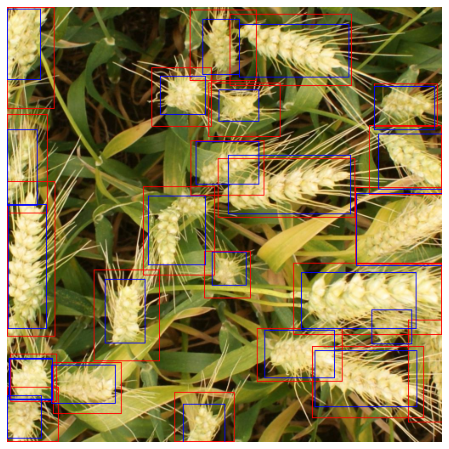

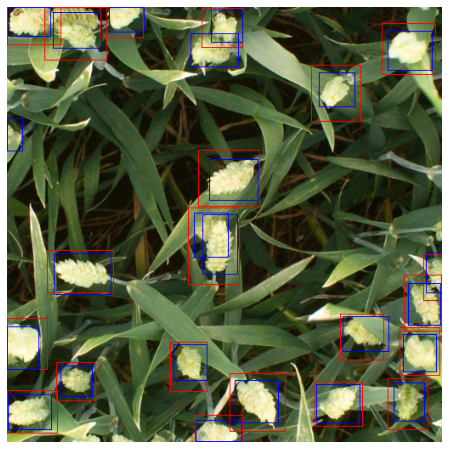

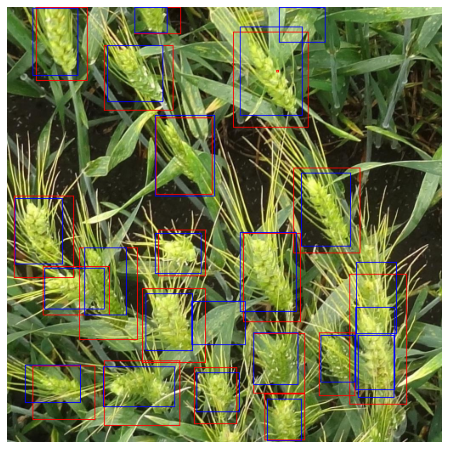

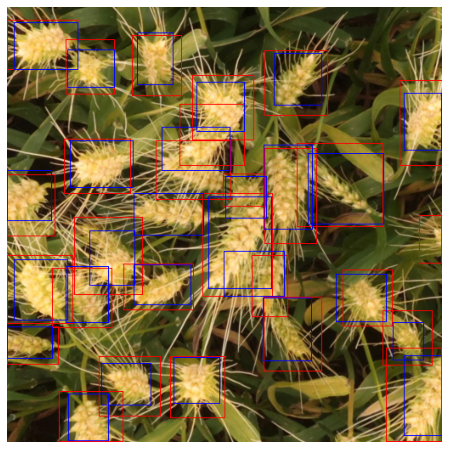

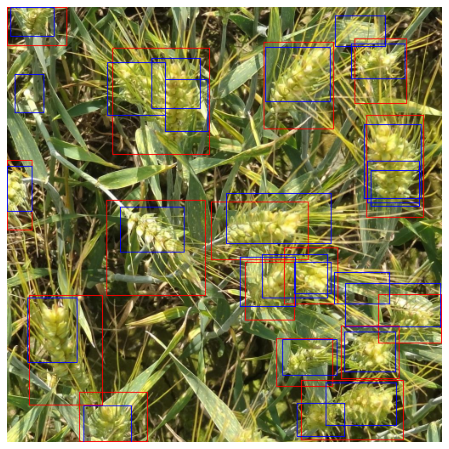

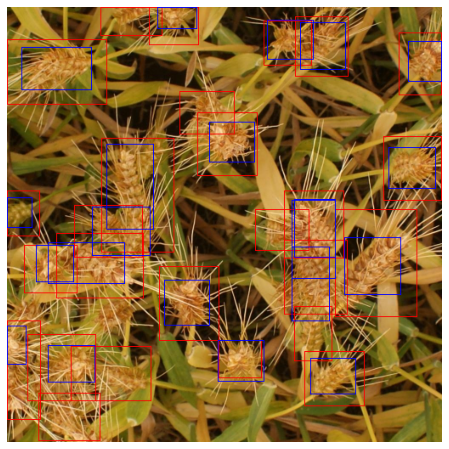

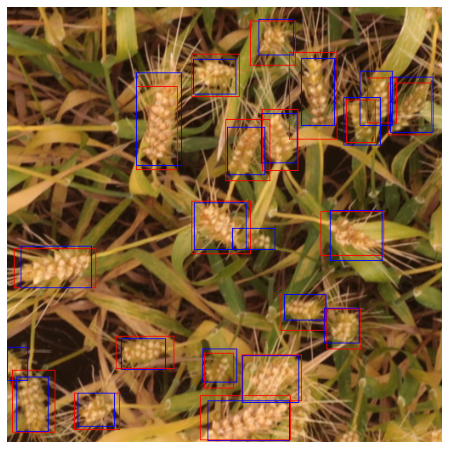

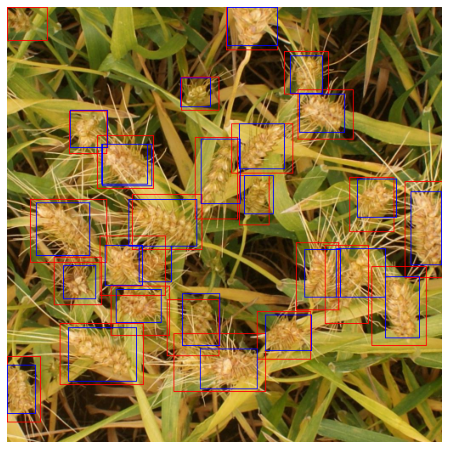

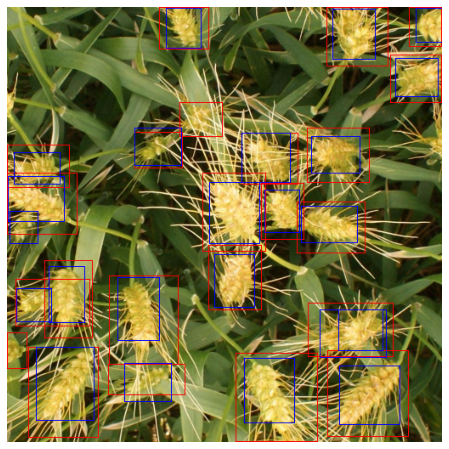

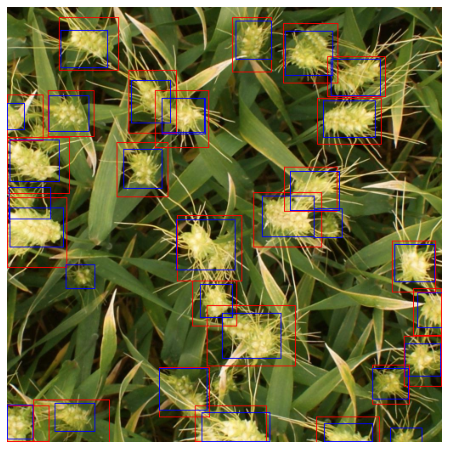

In [35]:
np_all_pred_boxes, np_all_test_boxes = predict_and_view(test_data_loader, model, confidence_threshold=confidence_threshold)

## Evaluation

In [45]:
all_pred_boxes = []
all_test_boxes = []

for pred_boxes in np_all_pred_boxes:
    # Transpose the matrix of boxes
    pred_boxes = pred_boxes.transpose()
    # Convert to torch tensor
    pred_boxes = torch.from_numpy(pred_boxes)
    all_pred_boxes.append(pred_boxes)
    
for img_test_boxes in np_all_test_boxes:
    
    for box in img_test_boxes:
        box[2] = box[2]+box[0]
        box[3] = box[3]+box[1]
        
    # Convert to torch tensor
    img_test_boxes = torch.from_numpy(img_test_boxes)
    all_test_boxes.append(img_test_boxes)  

In [46]:
for i in range(10):
    print(all_pred_boxes[i].shape, ' -- ', all_test_boxes[i].shape)

torch.Size([25, 4])  --  torch.Size([23, 4])
torch.Size([25, 4])  --  torch.Size([21, 4])
torch.Size([24, 4])  --  torch.Size([20, 4])
torch.Size([28, 4])  --  torch.Size([28, 4])
torch.Size([26, 4])  --  torch.Size([16, 4])
torch.Size([22, 4])  --  torch.Size([26, 4])
torch.Size([23, 4])  --  torch.Size([20, 4])
torch.Size([27, 4])  --  torch.Size([25, 4])
torch.Size([24, 4])  --  torch.Size([23, 4])
torch.Size([32, 4])  --  torch.Size([26, 4])


In [47]:
def find_intersection(box, test_boxes):
    """Find the intersection of every box combination between two sets of boxes that are in boundary coordinates.
    """
    # PyTorch auto-broadcasts singleton dimensions
    lower_bounds = torch.max(box[:, :2].unsqueeze(1), test_boxes[:, :2].unsqueeze(0))  
    upper_bounds = torch.min(box[:, 2:].unsqueeze(1), test_boxes[:, 2:].unsqueeze(0))  
    intersection_dims = torch.clamp(upper_bounds - lower_bounds, min=0)  
    
    return intersection_dims[:, :, 0] * intersection_dims[:, :, 1]  


def find_iou(box, test_boxes):
    """Find IoU overlap of every box combination between two sets of boxes that are in boundary coordinates.
    """        
    # Find intersections
    intersection = find_intersection(box, test_boxes)  

    # Find areas of each box in both sets
    areas_box = (box[:, 2] - box[:, 0]) * (box[:, 3] - box[:, 1])  
    areas_test_boxes = (test_boxes[:, 2] - test_boxes[:, 0]) * (test_boxes[:, 3] - test_boxes[:, 1]) 

    # Find the union
    union = areas_box.unsqueeze(1) + areas_test_boxes.unsqueeze(0) - intersection  

    return intersection / union 

In [48]:
def AP(test_boxes, pred_boxes):
    """Calculate AP score of the prediction.
    """
    average_precisions = torch.zeros((0), dtype=torch.float)
    
    num = 0
    if test_boxes.size(0) > pred_boxes.size(0):
        num = test_boxes.size(0)
    else:
        num = pred_boxes.size(0)
        
    true_pos = torch.zeros((num), dtype=torch.float).to(device) 
    false_pos = torch.zeros((num), dtype=torch.float).to(device)  
    

    for box in test_boxes:
        this_box = box.unsqueeze(0)
        overlaps = find_iou(this_box, pred_boxes)
        max_overlap, idx = torch.max(overlaps.squeeze(0), dim=0)
        
        # Need it to pop detected box
        og_id = torch.LongTensor(range(pred_boxes.size(0)))[idx]
        pred_boxes = torch.cat([pred_boxes[0:og_id], pred_boxes[og_id+1:]])
        
        if max_overlap.item() >= 0.5:
            true_pos[idx] = 1
            
        else:
            false_pos[idx] = 1
        
        if pred_boxes.size(0) == 0:
            break
        
    
    sum_true_pos = torch.cumsum(true_pos, dim=0)
    sum_false_pos = torch.cumsum(false_pos, dim=0)
    
    
    # High precision means the accuracy of the bboxes found is high. 
    arr_precision = sum_true_pos / (
                sum_true_pos + sum_false_pos + 1e-10)
    # High recall means the rate of omitting the ground truth positive bboxes is low.
    arr_recall = sum_true_pos/test_boxes.size(0)
    
    
    # Order Precison and Recall like the ROC curve
    # Find the mean of the maximum of the precisions corresponding to recalls above the threshold 't'
    recall_thresholds = torch.arange(start=0, end=1.1, step=.1).tolist() # 0.0 ---> 1.0
    precisions = torch.zeros((len(recall_thresholds)), dtype=torch.float).to(device)
    
    for i, t in enumerate(recall_thresholds):
        recalls_above_t = arr_recall >= t
        if recalls_above_t.any():
            precisions[i] = arr_precision[recalls_above_t].max()
        else:
            precision[i] = 0.0
            
        average_precision = precisions.mean().item()
            
        
        
    return arr_precision, arr_recall, average_precision

In [49]:
# Display results and find mAP
APs = 0
mAP = 0


for i in range(10):
    num_overlap, num_predict = all_pred_boxes[i].size(0), all_test_boxes[i].size(0)
    
    precision = torch.zeros((num_predict), dtype=torch.float)
    recall = torch.zeros((num_predict), dtype=torch.float)
    
    precision, recall, average_precision = AP(all_pred_boxes[i], all_test_boxes[i])
    
    APs += average_precision
    mAP = APs/10
    
    print('Image {}:'.format(i+1), '\n', 'Number of Predicted boxes:', num_overlap, end='\n')
    print(' Number of Ground truth boxes:', num_predict, end='\n')
    
    # print('Precision score: ',precision, end = '\n')       
    # print('Rcall score: ', recall, end = '\n')
    
    
    print('AP score: ',average_precision, end = '\n')
    print('------------------------------------', end ='\n')
    
print('mAP score: ',mAP, end = '\n')

Image 1: 
 Number of Predicted boxes: 25
 Number of Ground truth boxes: 23
AP score:  1.2666232210656822e+28
------------------------------------
Image 2: 
 Number of Predicted boxes: 25
 Number of Ground truth boxes: 21
AP score:  1.0
------------------------------------
Image 3: 
 Number of Predicted boxes: 24
 Number of Ground truth boxes: 20
AP score:  0.5
------------------------------------
Image 4: 
 Number of Predicted boxes: 28
 Number of Ground truth boxes: 28
AP score:  6.468578450657958e-11
------------------------------------
Image 5: 
 Number of Predicted boxes: 26
 Number of Ground truth boxes: 16
AP score:  1.0
------------------------------------
Image 6: 
 Number of Predicted boxes: 22
 Number of Ground truth boxes: 26
AP score:  1.319289531325048e+28
------------------------------------
Image 7: 
 Number of Predicted boxes: 23
 Number of Ground truth boxes: 20
AP score:  1.0
------------------------------------
Image 8: 
 Number of Predicted boxes: 27
 Number of Grou

In [125]:
torch.cuda.empty_cache()

# References

[1] https://www.kaggle.com/shonenkov/training-efficientdet

[2],
[3],
[4],
[5]
https://www.kaggle.com/tanulsingh077/end-to-end-object-detection-with-transformers-detr

[6] https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-train
